# Simulator

In [1]:
import sys
sys.path.insert(0, "..")
import pandas as pd
import matplotlib.pyplot as plt
from trading_simulator import TradingSimulator, DLSimulator
from dl_solutions.dlsolutions import CryptoDLSolutions
from data_processor.data_processing import DataProcessor
from utils.crypto_utils import ModelAnalysis

Using TensorFlow backend.


## Classic

### Data preparation

In [ ]:
cryptos = ['ADA', 'BTC', 'ETH', 'LTC', 'LNK']
sel = 0

In [12]:
for crypto in cryptos:
    processor = DataProcessor([crypto])
    sim = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2, log = False)
    sim.simulate()

Loading... ADA


KeyboardInterrupt: 

In [ ]:
processor = DataProcessor([crypto])
sim1 = TradingSimulator(processor, crypto, strategy = [1], loss_allowed = 0.2)
sim2 = TradingSimulator(processor, crypto, strategy = [2], loss_allowed = 0.2)
sim3 = TradingSimulator(processor, crypto, strategy = [3], loss_allowed = 0.2)
sim4 = TradingSimulator(processor, crypto, strategy = [4], loss_allowed = 0.2)
sim5 = TradingSimulator(processor, crypto, strategy = [5], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [6], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [7], loss_allowed = 0.2)
sim7 = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2)

### Simulations

In [ ]:
sim1.simulate()

In [ ]:
sim2.simulate()

In [ ]:
sim3.simulate()

In [ ]:
sim4.simulate()

In [ ]:
sim5.simulate()

In [ ]:
sim6.simulate()

In [ ]:
sim7.simulate()

## DL Solution

In [2]:
model_analysis = ModelAnalysis()

def execute_test():
    '''
    Creates artificial test process to validate different hyperparameters
    '''
    sim = DLSimulator(crypto, prev_periods, pred_periods, columns, target,
    norm_strat, model_sel, layers, neurons, batch_size, epochs, 
    activation, loss, metrics, optimizer, initial_learning_rate, callbacks)

    df_train = sim.get_df().iloc[:-1]
    df_test = sim.get_df().iloc[-1:]
    
    sim.train_model(df_train)
    
    pred = sim.predict(pd.DataFrame(df_test))
    print('Predictions', pred)
    h = sim.get_history()
    model_analysis.draw_history(h)

### Data preparation

We'll write all base paramteers and change them during the analysis process to obtain the best DL Solution for the posterior usage in the simulation

In [3]:
crypto = 'ETH'

#### PERIODS ####
prev_periods = 20
pred_periods = 20


#### COLUMNS ####
columns_1 = ['RSI', 'close']
columns_2 = ['ADX', 'close']
columns_4 = ['SO_K', 'close']
columns_5 = ['SMA 50']
columns_6 = ['EMA 50']
columns_7 = ['close_diff_10']
columns_8 = ['operation'] # Usar softmax

#### HYPERPARAMETERS ####
norm_strat = 2
layers = 4
neurons = [25, 25, 25, 25]
batch_size = 64
epochs = 100
#activations = ['relu', 'sigmoid', 'softmax']
#losses = ['mse', 'binary_crossentropy', 'categorical_crossentropy']
#metrics_opt = ['mse', 'accuracy']
activation = 'relu'
loss = 'mse'
metrics = ['mse']
optimizer = 'adam'
initial_learning_rate = 0.01
callbacks = ['mc']

### DL parameters and training

Creation of different strategies:

- Based on result
- Based on close/indicators normalized
- Try with different close distances
- Multioutput
- Based on multiple operation (softmax)

#### LSTM vs GRU

In [4]:
model_sel = 0

##### Multiples features

Usaremos multiples características como objetivos de predicción

In [5]:
target = None

Periods analysis

- Different previous periods used
- Different number of future periods to predict

For each period parameters used:

- Different metrics used
- Different hiper parameters
    - Different stretegies

Loading... ETH
Extracting columns columns for ETH
Proccessing and arranging columns for LSTM model
Input shape: (1446, 5, 2) (1446, 2) (0, 5, 2) (0, 2)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None

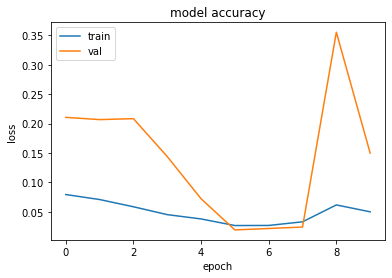

In [6]:
columns = columns_1
num_features = len(columns)

execute_test()

##### One line feature

Usaremos solo una característica como objetivo de predicción

In [ ]:
target = 'close'

#### GRU

In [ ]:
model_sel = 1

## Complete simulation

Complete strategy definition. Let the machine work through all the dataset